Running: N=5, M=1, K=1
Running: N=5, M=2, K=2
Running: N=5, M=4, K=4
Running: N=5, M=4, K=8
Running: N=5, M=8, K=4
Running: N=10, M=1, K=1
Running: N=10, M=2, K=2
Running: N=10, M=4, K=4
Running: N=10, M=4, K=8
Running: N=10, M=8, K=4
Running: N=20, M=1, K=1
Running: N=20, M=2, K=2
Running: N=20, M=4, K=4
Running: N=20, M=4, K=8
Running: N=20, M=8, K=4
Running: N=50, M=1, K=1
Running: N=50, M=2, K=2
Running: N=50, M=4, K=4
Running: N=50, M=4, K=8
Running: N=50, M=8, K=4


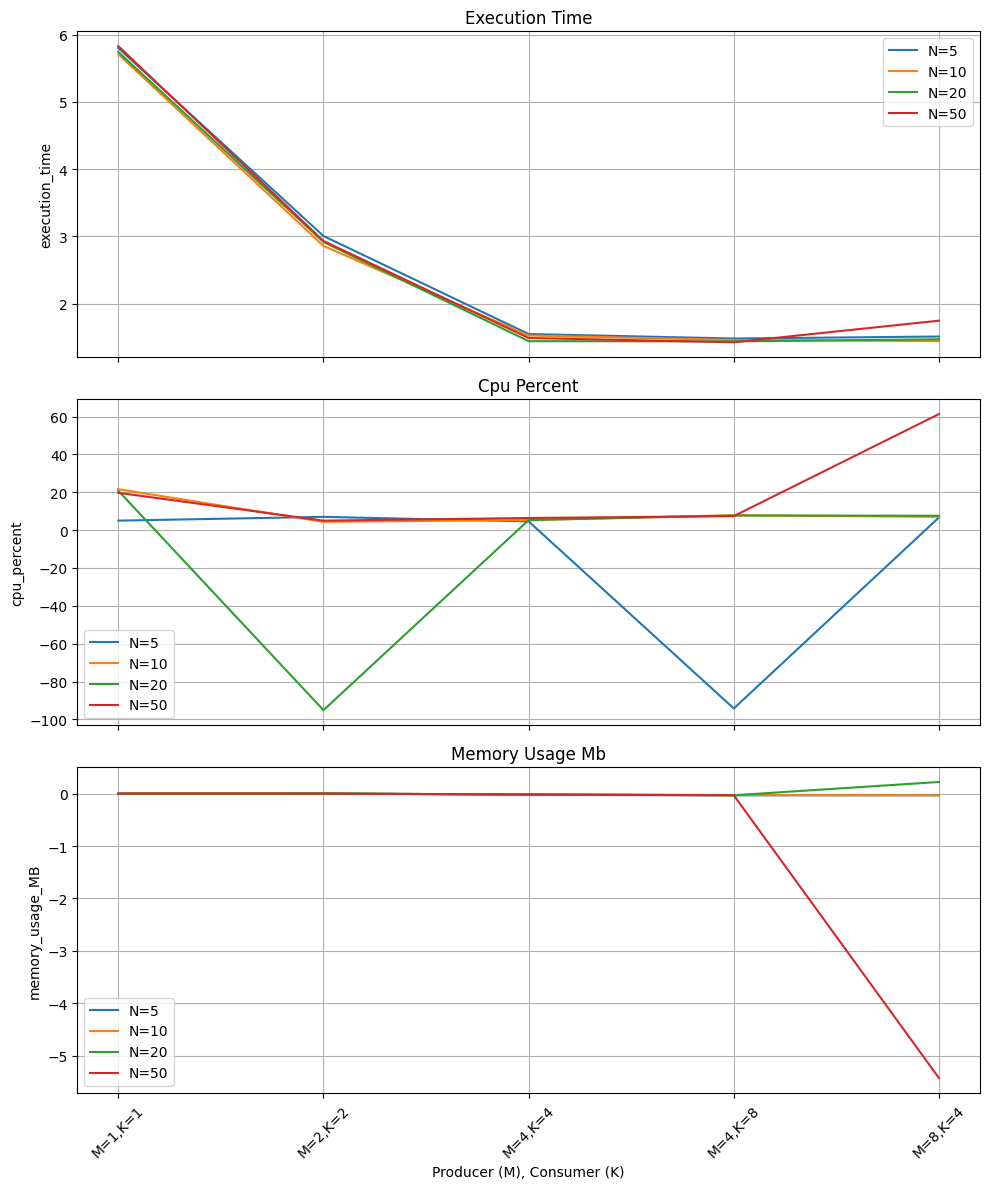

In [2]:
import threading
import queue
import time
import psutil
import matplotlib.pyplot as plt
import os
import random

# Bounded Buffer using threading

class BoundedBuffer:
    def __init__(self, size):
        self.buffer = queue.Queue(maxsize=size)
        self.lock = threading.Lock()

    def produce(self, item):
        self.buffer.put(item)

    def consume(self):
        return self.buffer.get()

    def task_done(self):
        self.buffer.task_done()

    def join(self):
        self.buffer.join()

# Producer and Consumer Functions

def producer_task(buffer, producer_id, produce_count):
    for _ in range(produce_count):
        item = random.randint(1, 100)
        buffer.produce(item)
        time.sleep(random.uniform(0.001, 0.01))

def consumer_task(buffer, consumer_id, consume_count):
    for _ in range(consume_count):
        item = buffer.consume()
        buffer.task_done()
        time.sleep(random.uniform(0.001, 0.01))

# Performance Benchmark Function

def run_benchmark(N, M, K, total_items):
    buffer = BoundedBuffer(N)
    items_per_producer = total_items // M
    items_per_consumer = total_items // K

    producers = []
    consumers = []

    # Monitor system resources
    process = psutil.Process(os.getpid())
    start_cpu = psutil.cpu_percent(interval=None)
    start_mem = process.memory_info().rss / 1024 / 1024  # in MB

    start_time = time.time()

    # Create producers
    for i in range(M):
        t = threading.Thread(target=producer_task, args=(buffer, i, items_per_producer))
        producers.append(t)

    # Create consumers
    for i in range(K):
        t = threading.Thread(target=consumer_task, args=(buffer, i, items_per_consumer))
        consumers.append(t)

    # Start all threads
    for t in producers + consumers:
        t.start()

    # Wait for producers to finish
    for t in producers:
        t.join()

    # Wait for consumers to finish
    buffer.join()

    for t in consumers:
        t.join()

    end_time = time.time()
    end_cpu = psutil.cpu_percent(interval=None)
    end_mem = process.memory_info().rss / 1024 / 1024  # in MB

    return {
        'execution_time': end_time - start_time,
        'cpu_percent': end_cpu - start_cpu,
        'memory_usage_MB': end_mem - start_mem
    }

# Run Experiments and Plot Graphs

def experiment():
    total_items = 1000
    buffer_sizes = [5, 10, 20, 50]
    producer_consumer_counts = [(1, 1), (2, 2), (4, 4), (4, 8), (8, 4)]

    results = []

    for N in buffer_sizes:
        for M, K in producer_consumer_counts:
            print(f"Running: N={N}, M={M}, K={K}")
            metrics = run_benchmark(N, M, K, total_items)
            results.append({
                'N': N,
                'M': M,
                'K': K,
                **metrics
            })

    return results

def plot_results(results):
    import pandas as pd
    df = pd.DataFrame(results)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    for metric, ax in zip(['execution_time', 'cpu_percent', 'memory_usage_MB'], axs):
        for N in sorted(df['N'].unique()):
            subset = df[df['N'] == N]
            labels = [f"M={m},K={k}" for m, k in zip(subset['M'], subset['K'])]
            ax.plot(labels, subset[metric], label=f"N={N}")
        ax.set_title(metric.replace("_", " ").title())
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    plt.xticks(rotation=45)
    plt.xlabel("Producer (M), Consumer (K)")
    plt.tight_layout()
    plt.show()

# Execute Everything

results = experiment()
plot_results(results)
